# Numerical Modeling of Heat Transfer

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


We will need ``sparse`` library

In [3]:
import numpy as np
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve

# Evolutionary  solution

The evolutionary (time-dependent) solution of heat equation require initial conditions, which deviate from steady-state solution. In this exercise we will

  1. Calculate steady-state solution
  2. Alter the solution to push it out of steady-state equilibrium
  3. We will solve evolutionary equation to track how system getting back towards the equilibrium

**Keep in mind, that steady-state solution is the one with zero time-derivate, so there is no change in time.**

## 1. Calculate steady-state solution

Here we will use stedy state solution from last exercise, we just increase number of nodes for better resolution.

In [4]:
T0 = 0       # Surface temperature
H = 1e-6     # Heat production
k = 2.5      # conductivity
q = -32e-3   # mantle heat flow
n = 50       # number of nodes
th = 35000   # thickness of the crust

In [5]:
dx = th/ ( n - 1)           # node spacing
x = linspace(0, th, n)  # node positions
d = ones(n)             # diagonals helper

In [6]:
# coeficient matrix A
A = spdiags([d, -2*d, d], [-1, 0, 1], n, n, 'csr')
A[0, :2] = [1, 0]
A[-1, -2:] = [2, -2]

In [7]:
# vector of constant terms b
b = d * (-H * dx**2 ) / k
b[0] = T0
b[-1] = (q * 2 * dx - H * dx**2) / k

Thats it. Now just solve and plot. Note use of ``spsolve``

In [8]:
T = spsolve(A, b)

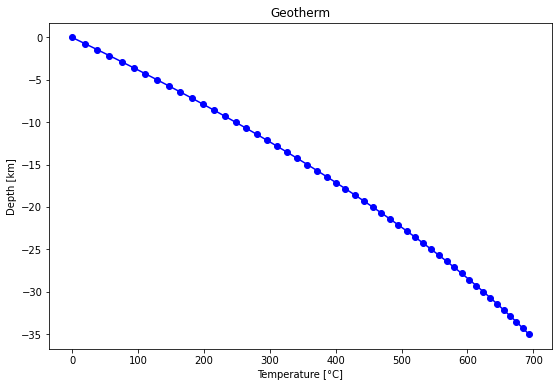

In [9]:
figure(figsize=(9, 6))
plot(T, -x/1000, "bo-")
xlabel('Temperature [°C]')
ylabel('Depth [km]')
title('Geotherm');

## 2. Alter the solution to push it out of steady-state equilibrium

In our first case we will imagine instantaneous intrusion of hot magmatic rock between 10-15 km depth with temperature 700°C

In [10]:
T[(x>=10000) & (x<=15000)] = 700

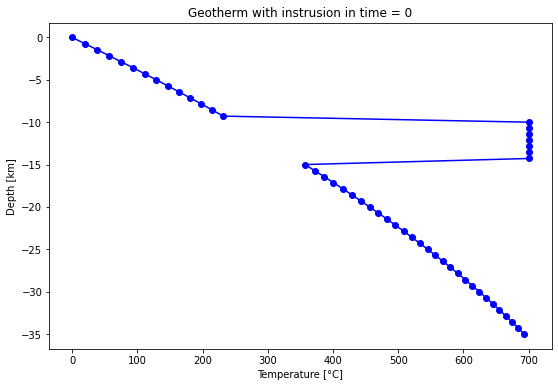

In [11]:
figure(figsize=(9, 6))
plot(T, -x/1000, "bo-")
xlabel('Temperature [°C]')
ylabel('Depth [km]')
title('Geotherm with instrusion in time = 0');

## 3. Evolutionary (time-dependent) solution

At first we set parameters of the model. Note that we need *density* and *specific heat* for time-dependent problems. We also introduce *ysec* variable to express time in seconds using years and *dt* for time step

In [12]:
T0 = 0                     # Surface temperature
H = 1e-6                   # Heat production
k = 2.5                    # conductivity
q = -32e-3                 # mantle heat flow
n = 50                     # number of nodes
th = 35000                 # thickness of the crust
rho = 2700                 # density                <<< time-dependent parameter
c = 900                    # specific heat          <<< time-dependent parameter
ysec = 365.25 * 24 * 3600  # one year in seconds
dt = 100 * ysec            # time step of hundred years

Here we calculate derived parameters as node spacing (used for calculations), node positions (used for plotting) and thermal diffusivity

In [13]:
dx = th / (n - 1)           # node spacing
x = linspace(0, th, n)  # node positions
kappa = k / (rho * c)       # thermal diffusivity
d = ones(n)             # diagonals helper

Calculate and check Fourier number (for stability)

In [14]:
u = kappa * dt / dx**2
print('u={:g} - OK'.format(u) if u<=0.5 else 'u={:g} - Unstable'.format(u))

u=0.00636347 - OK


Now we assemble coefficient matrix using Dirichlet boundary at surface and Neumann boundary condition at MOHO

In [15]:
A = spdiags([d * u, 1 - 2* d * u, d * u], [-1, 0, 1], n, n, 'csr')
A[0, :2] = [1, 0]
A[-1, -2:] = [2 * u, 1 - 2 * u]

Now create column vector of additional terms

In [16]:
b = d * H * dt / (rho * c)
b[0] = 0
b[-1] -= 2 * dt * q / (rho * c * dx)

Now we can calculate time evolution. We will do 500 calculations, each for 100 years  time-step, i.e. we will calculate temperature distribution after 50000 years.

In [17]:
Tn = T.copy()
for i in range(500):
    Tn = A.dot(Tn) + b

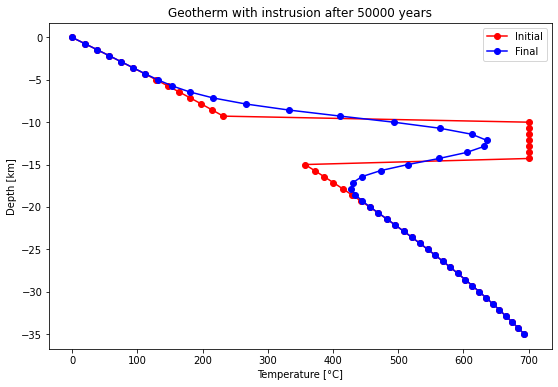

In [18]:
figure(figsize=(9, 6))
plot(T, -x/1000, 'ro-', label='Initial')
plot(Tn, -x/1000, 'bo-', label='Final')
xlabel('Temperature [°C]')
ylabel('Depth [km]')
legend()
title('Geotherm with instrusion after 50000 years');

What is the temperature in the middle of the intriusion after 50000 years?

The vector *Tn* contains solutions at our grid nodes, but likely there is not node a=exactly at depth 12.5 km. So easiest way is to interpolate temperature at this depth from calculated values.

In [19]:
Tx = interp(12500, x, Tn)
print('Temperature at depth 12.5 km is {:g}°C'.format(Tx))

Temperature at depth 12.5 km is 633.637°C


## Homework Exercise

Plot diagram of time vs. temperature for point in the middle of the intrusion during 1 milion years of cooling.

Text(0.5, 1.0, 'Geotherm with instrusion after 1 000 000 years')

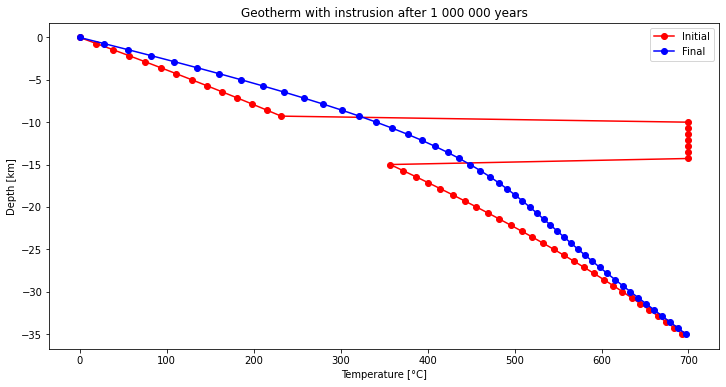

In [20]:
Ts = [T.copy()]
ts = [0]


for i in range(1, 10_000): # each step spans 100 years
    ts.append(i)
    Ts.append(A.dot(Ts[-1]) + b)


figure(figsize=(12, 6))

plot(Ts[0],  -x / 1000, 'ro-', label='Initial')
plot(Ts[-1], -x / 1000, 'bo-', label='Final')

xlabel('Temperature [°C]')
ylabel('Depth [km]')
legend()
title('Geotherm with instrusion after 1 000 000 years')


No handles with labels found to put in legend.


Text(0.5, 1.0, 'Temperature in the middle of intrussion (12 500 km) in 1 000 000 years')

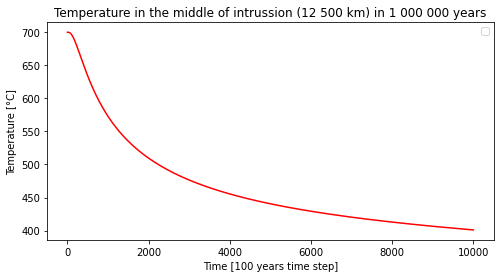

In [21]:
T_mid = [ interp(12500, x, T) for T in Ts ]

figure(figsize=(8, 4))

plot(ts, T_mid, "r-") 
xlabel('Time [100 years time step]')
ylabel('Temperature [°C]')
legend()
title('Temperature in the middle of intrussion (12 500 km) in 1 000 000 years')

Plot same diagram of time vs. temperature, but for 3 different points in depths 9, 12.5 and 16 km during 2 Ma of cooling.

**Question**: In what time the temperature in the middle of the intrusion will be lower than in 16km depth?

Text(0.5, 1.0, 'Geotherm with instrusion after 2 000 000 years')

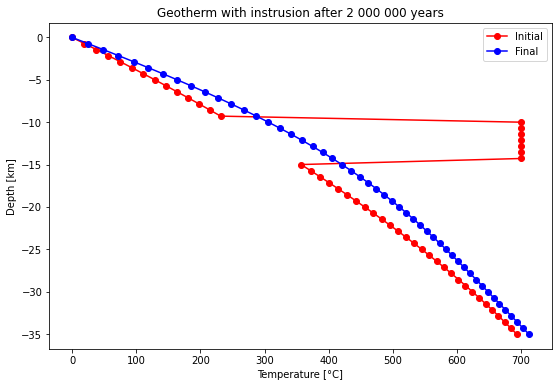

In [22]:
Ts = [T.copy()] # temperature field
ts = [0]        # time 

for i in range(1, 20_000): # each step spans 100 years
    ts.append(i)
    Ts.append(A.dot(Ts[-1]) + b)

figure(figsize=(9, 6))

plot(Ts[0],  -x / 1000, 'ro-', label='Initial')
plot(Ts[-1], -x / 1000, 'bo-', label='Final')

xlabel('Temperature [°C]')
ylabel('Depth [km]')
legend()
title('Geotherm with instrusion after 2 000 000 years')

2221


Text(0.5, 1.0, 'Temperature evolution in 2 000 000 years')

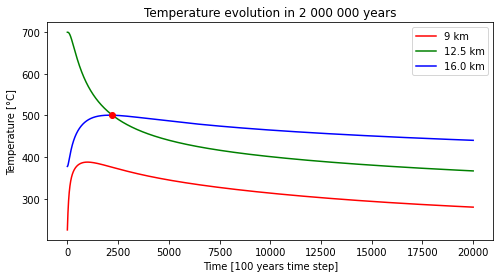

In [23]:
T1, T2, T3 = [ 
    [interp(d, x, T) for T in Ts] for d in (9_000, 12_500, 16_000)
]

# T_9000  = [interp(9000, x, _)  for _ in Ts]
# T_12500 = [interp(12500, x, _) for _ in Ts]
# T_16000 = [interp(16000, x, _) for _ in Ts]

figure(figsize=(8, 4))

plot(ts, T1, "r-", label="9 km")
plot(ts, T2, "g-", label="12.5 km")
plot(ts, T3, "b-", label="16.0 km")

# Tdiff = np.abs(array(T2) - array(T3))               # Get diffrencees between T2, T3.
# index = np.where(Tdiff == np.amin(Tdiff))[0].item() # Get index of minimum value.

index = np.abs(array(T2) - array(T3)).argmin()

print(index)

plot(ts[index], T3[index], "ro")

xlabel('Time [100 years time step]')
ylabel('Temperature [°C]')
legend()
title('Temperature evolution in 2 000 000 years')

In [24]:
print(f"In {index * 100} years after the intrusion the temperature in 12.5 km depth will be always lower then in 16km depth.")

In 222100 years after the intrusion the temperature in 12.5 km depth will be always lower then in 16km depth.
